# Date-a-Scientist
This is a Machine Learningproject that encourages thinking and practical


In recent years, there has been a massive rise in the usage of dating apps to find love. Many of these apps use sophisticated data science techniques to recommend possible matches to users and to optimize the user experience. These apps give us access to a wealth of information that we’ve never had before about how different people experience romance.

In this portfolio project, you will analyze some data from OKCupid, an app that focuses on using multiple choice and short answers to match users

## Introduction

Objective: 
- Create a recommendation engine
it will be a feature recommendation engine
KMeans clustering to order the data and derive recommendations from clusters

Steps followed in this project
1. Clean the data
    - drop unused columns
    - look into missing values
    - look for errors in column inputs (misspelling, incoherent values, falsy values)
2. Feature engineering
    - derive other columns from existing ones
    - pca
3. Create and tune model
    - elbow model for kmeans
    - output class for new data
    - Output recommendations
4. Conclusions and further research

## Clean the data

First, import the necessary libraries and tools, to then start by peeking into the dataset and the information it contains. We can see that there are some columns that contain text (named essay0, essay1, etc.) since the algorithm will not perform Natural Language Processing, I will drop these columns and investigate the rest.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import BinaryEncoder

%matplotlib inline

In [2]:
df = pd.read_csv('profiles.csv')
df.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,...,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


In [3]:
df.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [4]:
features = df[ [col for col in df.columns if 'essay' not in col] ]
features.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity',
       'height', 'income', 'job', 'last_online', 'location', 'offspring',
       'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes', 'speaks',
       'status'],
      dtype='object')

In this stage of the project, I will deal with the missing values in every column, I will also look at each column individually to understand if the values need further processing, such as tranformations or rearrangement, wich will be done as part of the feature engineering step of this project. These are the actions that I will perform in this cleaning step:

- Columns with complete entries: These columns do not have missing values, but I will look at them in future steps to see if they have mistakes like incorrect values. The columns in this group are: <br> `age`, `income`, `last_online`, `location`, `orientation`, `sex` and `status`.
- Columns with missing information: The `offspring` column is missing almost 60% of all entries, it will be dropped due to lack of information.
- Columns with little missing values: `speaks` and `height` are missing a small number of entries, so the rows with the missing data will be dropped
- Columns to analyze individually: These columns will be analyzed one by one, to determine the best course of action for each one. The columns in this group are: <br> `body_type`, `diet`, `drinks`, `drugs`, `education`, `ethnicity`, `job`, `pets`, `religion`, `sign` and `smokes`.

In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   ethnicity    54266 non-null  object 
 7   height       59943 non-null  float64
 8   income       59946 non-null  int64  
 9   job          51748 non-null  object 
 10  last_online  59946 non-null  object 
 11  location     59946 non-null  object 
 12  offspring    24385 non-null  object 
 13  orientation  59946 non-null  object 
 14  pets         40025 non-null  object 
 15  religion     39720 non-null  object 
 16  sex          59946 non-null  object 
 17  sign         48890 non-null  object 
 18  smokes       54434 non-null  object 
 19  spea

In [6]:
for column in features.columns:
    print(column)
    missing_values = features[column].isna().sum()
    print(f'Missing values: {missing_values}')
    print(f'Percentage missing values: {missing_values / len(features[column]) : .2%}', '\n')

age
Missing values: 0
Percentage missing values:  0.00% 

body_type
Missing values: 5296
Percentage missing values:  8.83% 

diet
Missing values: 24395
Percentage missing values:  40.69% 

drinks
Missing values: 2985
Percentage missing values:  4.98% 

drugs
Missing values: 14080
Percentage missing values:  23.49% 

education
Missing values: 6628
Percentage missing values:  11.06% 

ethnicity
Missing values: 5680
Percentage missing values:  9.48% 

height
Missing values: 3
Percentage missing values:  0.01% 

income
Missing values: 0
Percentage missing values:  0.00% 

job
Missing values: 8198
Percentage missing values:  13.68% 

last_online
Missing values: 0
Percentage missing values:  0.00% 

location
Missing values: 0
Percentage missing values:  0.00% 

offspring
Missing values: 35561
Percentage missing values:  59.32% 

orientation
Missing values: 0
Percentage missing values:  0.00% 

pets
Missing values: 19921
Percentage missing values:  33.23% 

religion
Missing values: 20226
Perc

In [7]:
features = features.drop('offspring', axis=1)

In [8]:
features = features.dropna(subset=['speaks','height'])

### Body type

This values are categorical, and can be filled with the most common category. There are also a lot of different categories, so I will group them to reduce dimensionality, and in further steps, these will be encoded using ono-hot encoding.

| New category | Old categories | 
| --- | --- |
| thin | this, skinny, used up |
| average | average |
| fit | fit, athletic, jacked |
| curvy | curvy, a little extra, full figured, overweight |
| rather not say | rather not say |

In [9]:
features['body_type'].value_counts()

average           14643
fit               12704
athletic          11809
thin               4706
curvy              3923
a little extra     2626
skinny             1774
full figured       1008
overweight          443
jacked              421
used up             355
rather not say      194
Name: body_type, dtype: int64

In [10]:
#Fill missing values with mode
features['body_type'] = features['body_type'].fillna('average')
#Reorder categories
def reorder_body_type(x):
    if x in ('thin', 'skinny', 'used up'):
        return 'thin'
    elif x in ('average', 'rather not say'):
        return x
    elif x in ('fit', 'athletic', 'jacked'):
        return 'fit'
    else:
        return 'curvy'
features['body_type'] = features['body_type'].apply(reorder_body_type)

### Diet

Fill missing values with 'anything', assuming that if this was important (or respondent had special needs), people would have filled with appropriate value. There are a lot of categories, in order to reduce complexity, I am going to create new categories from the old values as follows:

| New category | Old categories | 
| --- | --- |
| anything | 'mostly anything', 'anything', 'strictly anything' |
| vegetarian | 'mostly vegetarian', 'strictly vegetarian', 'vegetarian' |
| vegan | 'mostly vegan', 'strictly vegan', 'vegan' |
| special | 'mostly kosher', 'mostly halal', 'strictly halal', 'strictly kosher', 'halal', 'kosher' |
| other | 'mostly other', 'strictly other', 'other' |

In [11]:
features['diet'].value_counts()

mostly anything        16577
anything                6179
strictly anything       5110
mostly vegetarian       3440
mostly other            1007
strictly vegetarian      875
vegetarian               666
strictly other           451
mostly vegan             338
other                    331
strictly vegan           228
vegan                    136
mostly kosher             86
mostly halal              48
strictly halal            18
strictly kosher           18
halal                     11
kosher                    11
Name: diet, dtype: int64

In [12]:
features['diet'] = features['diet'].fillna('anything')

In [13]:
def new_diet_categories(diet):
    if diet in ['mostly anything', 'anything', 'strictly anything']:
        return 'anything'
    elif diet in ['mostly vegetarian', 'strictly vegetarian', 'vegetarian']:
        return 'vegetarian'
    elif diet in ['mostly vegan', 'strictly vegan', 'vegan']:
        return 'vegan'
    elif diet in ['mostly kosher', 'mostly halal', 'strictly halal', 'strictly kosher', 'halal', 'kosher']:
        return 'special'
    else:
        return 'other'
features['diet'] = features['diet'].apply(new_diet_categories)

### Drinks

Replace missing values with the mode

In [14]:
features.drinks.value_counts()

socially       41750
rarely          5954
often           5161
not at all      3266
very often       470
desperately      322
Name: drinks, dtype: int64

In [15]:
features['drinks'] = features['drinks'].fillna('socially')

### Drugs

Replace missing values with the mode

In [16]:
features.drugs.value_counts()

never        37700
sometimes     7730
often          410
Name: drugs, dtype: int64

In [17]:
features['drugs'] = features['drugs'].fillna('never')

### Education

Replace missing values with the mode. This column has a lot of categories, and I can't think of some logical groupping for all the different categories. Therefore, I will use Binary Encoding for this column, which will keep all the categories and transform them into a binary representation (encoding will be done in another step).

In [18]:
features.education.value_counts()

graduated from college/university    23938
graduated from masters program        8950
working on college/university         5712
working on masters program            1682
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1270
graduated from law school             1122
working on two-year college           1073
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  211
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out of ph.d program            127
dropped out

In [19]:
features.education = features.education.fillna('graduated from college/university')

### Ethnicity

This column also had a lot of categories, which I grouped into fewer classes, but in doing so I changed the relative frequencies of the original types, putting `other` in second place while it was the fifth most common category before the transformation

In [20]:
features.ethnicity.value_counts()

white                                                                 32799
asian                                                                  6133
hispanic / latin                                                       2821
black                                                                  2006
other                                                                  1702
                                                                      ...  
middle eastern, indian, white                                             1
asian, middle eastern, black, white, other                                1
asian, middle eastern, indian, hispanic / latin, white, other             1
black, native american, indian, pacific islander, hispanic / latin        1
asian, black, indian                                                      1
Name: ethnicity, Length: 217, dtype: int64

In [21]:
ethnic_groups = ['white','asian','hispanic / latin','black','other']
features.ethnicity = features.ethnicity.apply(lambda x: x if x in ethnic_groups else 'other')
features.ethnicity.value_counts()

white               32799
other               16134
asian                6133
hispanic / latin     2821
black                2006
Name: ethnicity, dtype: int64

### Job

This column will also be filled with the mode. Since the number of categories is high, I don't find any obvious groupings, and it doesn't make sense to encode them into ordinal numbers, I will use another type of encoder called binary encoder for this column (this will be done in the feature engineering step)

In [22]:
features.job.value_counts()

other                                7587
student                              4880
science / tech / engineering         4844
computer / hardware / software       4707
artistic / musical / writer          4436
sales / marketing / biz dev          4385
medicine / health                    3675
education / academia                 3511
executive / management               2368
banking / financial / real estate    2264
entertainment / media                2250
law / legal services                 1381
hospitality / travel                 1363
construction / craftsmanship         1021
clerical / administrative             805
political / government                707
rather not say                        436
transportation                        366
unemployed                            273
retired                               250
military                              204
Name: job, dtype: int64

In [23]:
features.job = features.job.fillna('other')

### Pets

`pets` was also filled with the mode. In this case, I will derive 3 new columns to capture the information contained in the original `pets`. This will not require further encoding.

In [24]:
features.pets.value_counts()

likes dogs and likes cats          14806
likes dogs                          7220
likes dogs and has cats             4311
has dogs                            4133
has dogs and likes cats             2331
likes dogs and dislikes cats        2029
has dogs and has cats               1474
has cats                            1403
likes cats                          1061
has dogs and dislikes cats           552
dislikes dogs and likes cats         240
dislikes dogs and dislikes cats      196
dislikes cats                        122
dislikes dogs and has cats            81
dislikes dogs                         44
Name: pets, dtype: int64

In [25]:
features.pets = features.pets.fillna('likes dogs and likes cats')
#pets_likes_dogs
features['pets_likes_dogs'] = features['pets'].apply(lambda x: 1 if 'likes dogs' in x else 0)
#pets_likes_cats
features['pets_likes_cats'] = features['pets'].apply(lambda x: 1 if 'likes cats' in x else 0)
#has_pets
features['has_pets'] = features['pets'].apply(lambda x: 1 if 'has' in x else 0)
features = features.drop('pets', axis=1)

### Religion

There are 20226 missing values in `religion`, and the categories are all evenly distributed, so if the column is filled with the mode, the original values in the column will be heavily distorted.
After some consideration, I decided to drop the column because null values cannot be filled without skewing too much the distribution of the values, and dropping null values would drop many rows.

In [26]:
features.religion.isna().sum()

20213

In [27]:
features.religion.value_counts()

agnosticism                                   2716
other                                         2680
agnosticism but not too serious about it      2634
agnosticism and laughing about it             2495
catholicism but not too serious about it      2317
atheism                                       2173
other and laughing about it                   2118
atheism and laughing about it                 2074
christianity                                  1953
christianity but not too serious about it     1951
other but not too serious about it            1553
judaism but not too serious about it          1517
atheism but not too serious about it          1318
catholicism                                   1061
christianity and somewhat serious about it     927
atheism and somewhat serious about it          848
other and somewhat serious about it            846
catholicism and laughing about it              726
judaism and laughing about it                  680
buddhism but not too serious ab

In [28]:
features = features.drop('religion', axis=1)

### Sign

There are a lot of different categories in this column, I could use another binary encoding but I will try to instead derive part of the information contained in this column, by creating another column that only states the importance of zodiac signs to the responder

In [29]:
features.sign.value_counts()

gemini and it&rsquo;s fun to think about         1781
scorpio and it&rsquo;s fun to think about        1770
leo and it&rsquo;s fun to think about            1690
libra and it&rsquo;s fun to think about          1648
taurus and it&rsquo;s fun to think about         1638
cancer and it&rsquo;s fun to think about         1597
pisces and it&rsquo;s fun to think about         1592
sagittarius and it&rsquo;s fun to think about    1581
aries and it&rsquo;s fun to think about          1573
virgo and it&rsquo;s fun to think about          1573
aquarius and it&rsquo;s fun to think about       1503
virgo but it doesn&rsquo;t matter                1497
leo but it doesn&rsquo;t matter                  1456
cancer but it doesn&rsquo;t matter               1453
gemini but it doesn&rsquo;t matter               1453
taurus but it doesn&rsquo;t matter               1450
libra but it doesn&rsquo;t matter                1408
aquarius but it doesn&rsquo;t matter             1407
sagittarius but it doesn&rsq

In [30]:
features.sign = features.sign.fillna(0)

In [31]:
def zodiac_matters(x):
    if x == 0:
        return 0
    lst = x.split()
    if len(lst) == 1 or 'matters a lot' in x:
        return 1
    return 0
features.sign = features.sign.apply(zodiac_matters)

### Smokes

Just fill with the mode

In [32]:
features.smokes.value_counts()

no                43856
sometimes          3785
when drinking      3040
yes                2228
trying to quit     1477
Name: smokes, dtype: int64

In [33]:
features.smokes = features.smokes.fillna('no')

### Age
This starts the analysis of the columns that were complete, as above, I will go through every column to see if there are things that need to be changed. 
In particular, for the age column we see there are a couple entries where the answer is above 100, we will drop these assuming they were mistakes.

In [34]:
features.age.describe()

count    59893.000000
mean        32.336083
std          9.452751
min         18.000000
25%         26.000000
50%         30.000000
75%         37.000000
max        110.000000
Name: age, dtype: float64

In [35]:
features[ features['age']>90 ]

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,...,location,orientation,sex,sign,smokes,speaks,status,pets_likes_dogs,pets_likes_cats,has_pets
2512,110,average,anything,socially,never,graduated from college/university,other,67.0,-1,other,...,"daly city, california",straight,f,0,no,english,single,1,1,0
25324,109,fit,other,socially,never,working on masters program,other,95.0,-1,student,...,"san francisco, california",straight,m,0,when drinking,english (okay),available,1,1,0


In [36]:
features = features[features['age']<= 90]

### Income
This column was interesting. Despite being complete, most of the information is missing from this column. `80%` of respondents gave an answer of `-1`, which is akin to not responding at all and because of this the column will have to be dropped, due to lack of information 

In [37]:
features['income'].value_counts()

-1          48392
 20000       2952
 100000      1617
 80000       1111
 30000       1048
 40000       1005
 50000        974
 60000        736
 70000        707
 150000       631
 1000000      521
 250000       149
 500000        48
Name: income, dtype: int64

In [38]:
percentage_missing =  48237 / len(features.income)
print(f'{percentage_missing:.2%} "missing" answers')

80.54% "missing" answers


In [39]:
#This column is not usable
features = features.drop('income', axis=1)

### Location
I will drop this column also, this time because `99%` of the respondents are from `California`, which means most machine learning algorithms will not be able to derive useful patterns from this variable.

In [40]:
features.location.value_counts()

san francisco, california         31028
oakland, california                7213
berkeley, california               4209
san mateo, california              1330
palo alto, california              1062
                                  ...  
south wellfleet, massachusetts        1
orange, california                    1
astoria, new york                     1
london, united kingdom                1
rochester, michigan                   1
Name: location, Length: 198, dtype: int64

In [41]:
people_from_california = features['location'].str.match(".*california.*").sum()
total_people = len(features['location'])
percentage_from_california = people_from_california / total_people
print(f'Percentage of people from California: {percentage_from_california:.2%}')

Percentage of people from California: 99.85%


In [42]:
features = features.drop('location', axis=1)

### Last online
I will drop this column, since it is not relevant to the clusters we are trying to make

In [43]:
features = features.drop('last_online', axis=1)

### Orientation, Sex and Status
These columns are complete and have a reasonable number of categories each one, there is no further need of transformation except for the encoding in a future st

In [44]:
features.orientation.value_counts()

straight    51559
gay          5567
bisexual     2765
Name: orientation, dtype: int64

In [45]:
features.sex.value_counts()

m    35791
f    24100
Name: sex, dtype: int64

In [46]:
features.status.value_counts()

single            55646
seeing someone     2064
available          1861
married             310
unknown              10
Name: status, dtype: int64

### Speaks

Virtually all the answer in this column have `english` in them, tehrefore I will derive another column which states if the respondent talks more than one language

In [47]:
features.speaks.str.contains('english').sum()#Rows from people who speak English

59891

In [48]:
len(features.speaks)#Total rows

59891

In [49]:
features.speaks.value_counts()

english                                                                21826
english (fluently)                                                      6627
english (fluently), spanish (poorly)                                    2059
english (fluently), spanish (okay)                                      1917
english (fluently), spanish (fluently)                                  1288
                                                                       ...  
english (fluently), urdu (poorly), japanese (poorly), french (okay)        1
english, spanish, hindi, c++                                               1
english (fluently), japanese (okay), thai (okay), chinese (poorly)         1
english (fluently), french (okay), italian (okay), hebrew (okay)           1
english (fluently), french, farsi                                          1
Name: speaks, Length: 7647, dtype: int64

In [50]:
features['speaks_other_than_english'] = features.speaks.apply(lambda x: 1 if len(x.split()) > 1 else 0)

In [51]:
features['speaks_other_than_english'].value_counts()

1    38065
0    21826
Name: speaks_other_than_english, dtype: int64

In [52]:
features = features.drop('speaks', axis=1)

<hr>

## Feature engineering
This step will encode the columns with the correct technique, as assesed earlier. For some columns, we already applied transformations in the step above so there is no need for further processing.
I will also scale the columns, in order to be able to perform PCA in a later step

#### One-hot encoding
These columns were selected above to be changed into numbers using one-hot encoding

In [53]:
one_hot_columns = ['body_type', 'diet', 'drinks', 'drugs', 'ethnicity', \
                   'smokes', 'sex', 'status', 'orientation']
for col in one_hot_columns:
    dummies = pd.get_dummies(features[col], prefix=col, drop_first=True)
    features = features.join(dummies)
    features = features.drop(col, axis=1)

##### Binary encoding
This will be useful to encode the `jobs` and `education` columns without creating too much new columns

In [54]:
#To see the mapping of the Binary encoder uncomment the lines below

#jobs = BinaryEncoder(cols=['job'], drop_invariant=True)
#jobs.fit(features['job'])
#jobs.transform(features['job'].value_counts().index.to_series(name='job'))

In [55]:
#To see the mapping of the Binary encoder uncomment the lines below

# jobs = BinaryEncoder(cols=['education'], drop_invariant=True)
# jobs.fit(features['education'])
# jobs.transform(features['education'].value_counts().index.to_series(name='education'))

In [56]:
features = BinaryEncoder(cols=['education','job'], drop_invariant=True).fit_transform(features)
# features = features.drop(['education','job'], axis=1)

##### Scaling
The MinMaxScaler works well in this case because it adjusts the range of the variables between 0 and 1, this is perfect because so far qe have been assigning 0 or 1 to the transformation of the categorical variables (the majority of the columns)

In [57]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

<hr>

## Model
1. Utilize elbow method to optimize number of clusters
2. Use PCA to lower dimensionality and improve performance
3. Predict using a new point

##### PCA
Normally PCA is used to reduce the dimensions of the dataset into only 2, to be able to plot the variables and continue with the analysis. As the analysis is somewhat complete in the above sections, we will proceed to use PCA to reduce the dimensions and hopefully improve the performance of the clustering algorithm. Using the cumulative variance plot, 10 components seems a reasonable number of dimensions to use: it reduces the number of variables from 48 to 10, and it retains almost 98% of the variability of the dataset.

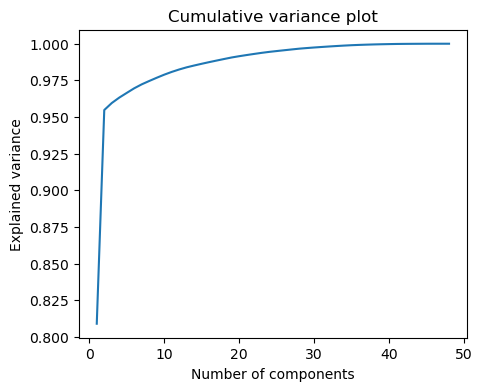

In [58]:
pca = PCA()
pca.fit(features)
plt.figure(figsize=(5,4))
plt.plot(range(1,len(features.columns)+1), pca.explained_variance_ratio_.cumsum())
plt.title('Cumulative variance plot')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

In [59]:
suma = 0
for i in range(10):
    suma += pca.explained_variance_ratio_[i]
print(f'Percentage of variance explained with only 10 components: {suma: .2%}')

Percentage of variance explained with only 10 components:  97.89%


In [60]:
#Setting the components to the parameter defined above
pca = PCA(n_components=10)
pca.fit(features)
new_features = pca.transform(features)

##### Elbow method
We will now tune the number of clusters used in the algorithm using the elbow method:
train a KMeans algorithm with a different value for the hyperparameter (number of clusters) and select a value that is not too high but performs well. 'Performs well' means that the inertia of the clusters is small.

Curiously, the plot below shows that 10 is also a good value for the number of clusters, so this is what we will use in the final version of the algorithm

In [61]:
#Use the elbow method to determine the optimal number of clusters
#It seems that the inertia starts to decrease more slowly at 10 clusters 

# num_clusters = [x for x in range(1, 55, 3)]
# inertias = []
# for k in num_clusters:
#     model = KMeans(n_clusters=k)
#     model.fit(new_features)
#     inertias.append(model.inertia_)
# plt.plot(num_clusters, inertias, '-o')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.show()

In [62]:
#Final, trained (fitted) version of the KMeans algorithm
best_num_clusters = 10
model = KMeans(n_clusters=best_num_clusters)
model.fit(new_features)

KMeans(n_clusters=10)

##### Prediction and recomendation
Now, to output a recommendation from this clusters. 
1. predict cluster labels for the original dataframe, concatenate this new column
2. make a prediction of a new point. This will signal the cluster in which this new point belongs
3. output a recommendation from the people in the original dataset who are in the same cluster as the new point (are most similar)

In [63]:
label = model.predict(new_features)
df = df[df.index.isin(features.index)]
df['label'] = label.tolist()

In [64]:
new_point = []
for col in features.columns:
    value=int(input(f'enter value for: {col}  '))
    new_point.append(value)

enter value for: age  29
enter value for: education_0  0
enter value for: education_1  0
enter value for: education_2  0
enter value for: education_3  1
enter value for: education_4  0
enter value for: education_5  0
enter value for: height  67
enter value for: job_0  0
enter value for: job_1  0
enter value for: job_2  1
enter value for: job_3  1
enter value for: job_4  1
enter value for: sign  0
enter value for: pets_likes_dogs  1
enter value for: pets_likes_cats  1
enter value for: has_pets  1
enter value for: speaks_other_than_english  1
enter value for: body_type_curvy  0
enter value for: body_type_fit  0
enter value for: body_type_rather not say  0
enter value for: body_type_thin  0
enter value for: diet_other  0
enter value for: diet_special  0
enter value for: diet_vegan  0
enter value for: diet_vegetarian  0
enter value for: drinks_not at all  0
enter value for: drinks_often  0
enter value for: drinks_rarely  0
enter value for: drinks_socially  1
enter value for: drinks_very of

In [72]:
new_point = np.array(new_point).reshape(1, 48)
new_point = scaler.transform(new_point)
pca_new_point = pca.transform(new_point)

/home/fillo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/fillo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [77]:
predicted_cluster = model.predict(pca_new_point)[0]
print(predicted_cluster)

8


In [79]:
preferred_orientation = 'straight'
preferred_sex = 'f'
possible_recommendations = df[ (df['label']==predicted_cluster) 
                              & (df['sex']==preferred_sex) 
                              & (df['orientation']==preferred_orientation
                            )]
possible_recommendations

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,label
8,24,NaN,strictly anything,socially,NaN,graduated from college/university,NaN,"oh goodness. at the moment i have 4 jobs, so i...",NaN,i'm freakishly blonde and have the same name a...,...,doesn&rsquo;t have kids,straight,likes dogs and likes cats,christianity but not too serious about it,f,gemini but it doesn&rsquo;t matter,when drinking,english,single,8
17,26,average,NaN,socially,never,working on college/university,to sum myself in whole: i have adventurous ten...,i'm currently studying and majoring in crimina...,hmm...i know i can take a test rather well.;) ...,physically-i've been told my eyes. people usua...,...,doesn&rsquo;t have kids,straight,NaN,NaN,f,aries and it&rsquo;s fun to think about,no,english,single,8
21,22,athletic,NaN,socially,never,working on college/university,my name is ashley and i live in san francisco....,i just graduated from usf with a major in inte...,NaN,"my smile. my eyes, and my hair apparently.",...,"doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,catholicism and somewhat serious about it,f,taurus but it doesn&rsquo;t matter,no,"english (fluently), spanish (fluently), italia...",single,8
30,27,average,anything,socially,NaN,working on college/university,iiiiiiiiiiiiiiiiii.... i hate talking about my...,the pursuit,NaN,NaN,...,NaN,straight,NaN,agnosticism,f,gemini,trying to quit,"english, spanish (poorly)",single,8
33,20,average,mostly vegetarian,socially,never,working on college/university,"""apparently,"" has become a new favorite word o...",working at a doggy daycare. it's really fun an...,being a girl...<br />\ncooking vegetarian cuis...,people start speaking to me in spanish and i r...,...,doesn&rsquo;t want kids,straight,has dogs and likes cats,NaN,f,cancer,no,"english (fluently), spanish (fluently)",single,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59912,25,skinny,NaN,socially,never,working on college/university,"well, lets see. the short and quick version is...",i'm just out here working and going to school ...,"procrastination! also, writing, videogames, mo...",usually it's my sleepy eyes. most people think...,...,"doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,christianity but not too serious about it,f,aries and it&rsquo;s fun to think about,yes,english,single,8
59914,26,average,mostly anything,rarely,never,working on college/university,i am in school so i may be less than responsiv...,finding myself. seriously. if you want a girl ...,beginners luck.<br />\nprocrastination.<br />\...,my big black and white dog who is usually at m...,...,NaN,straight,has dogs and has cats,NaN,f,cancer and it&rsquo;s fun to think about,no,english,single,8
59922,22,thin,vegetarian,socially,sometimes,working on college/university,just kind of a silly girl. super geek. ultra n...,i'm an anthropology/bioarchaeology major in sa...,procrastinating.<br />\nmaking a fool out of m...,i have no idea.,...,"doesn&rsquo;t have kids, and doesn&rsquo;t wan...",straight,likes dogs and likes cats,NaN,f,cancer but it doesn&rsquo;t matter,no,english (poorly),single,8
59924,25,NaN,NaN,socially,never,working on college/university,take clare from six feet under and sprinkle in...,ask me.,"making bad jokes, massage, creating experience...",i like dancing anywhere and everywhere to song...,...,NaN,straight,NaN,NaN,f,NaN,no,"english, french (poorly)",single,8


<hr>

## Conclusions
- bETTER ways to input information for new predictions
- The predictions are really good, they are like the people that are inputted
- the output were any number of profiles from the original dataset, this is because it is more human friendly than the modified features output.
- perhaps order the recommendations taking into account another cirteria

## Further research
- perhaps explore new ways of serendipity by new algorithm, clustering by other factors
- perhaps include some way to filter the results by the categories most important for the client (in this case they were sex, and orientation). Perhaps include this filters into the algorithm itself (e.g. different clusters according to different filters)